# Loan Default Prediction
## Background

LendingClub used to be the biggest peer to peer lending platform until 2020, when they changed their business focus. During its operation, LendingClub would establish a platform for borrowers and investors where borrowers were allowed to create loan requests on its website. They were also required to provide their information like credit score, credit history, desired loan amount and the debt-to-income ratio. Based on the data, LendingClub would decide if the loan request would be accepted and what the interest rate would be. Allowable loan range was between $1,000–40,000 and the return period was 3 or 5 years. Investors would make money from interest rates which were varied from 6.03% to 26.06%. LendingClub would make money from charging an origination fee to its borrowers and a service fee to its investors. The interest rates that LendingCub was offering were better for borrowers and lenders than most of banks and therefore, it was highly received.

When a request was made, based on the requester’s information such as credit history, LendingClub would decide to either accept or reject the request. For the accepted loans, a credit grade ranging from A to G would be assigned. The credit grade along with other factors would determine the interest rate. For the rejected loan a risk score was assigned. Furthermore, the credit grade would also determine the amount of the origination fee that the requester would be charged, and it would be between 1.1–5.0% of the loan amount. The size of the service fee, that the investor would be charged, would be 1% of all amounts the borrower would pay, which was the requested amount plus the total interest. Therefore, higher interest rates would generate more revenue. However, higher interest rates also indicate a riskier loan which may end up on default and may cause investment loss for LendingClub. Therefore, having a method to predict the risk factor accurately is very desirable. Statistical data shows that about 10% of loans will be defaulted. The question is if we can have a better risk analysis method and ultimately a strong predictive model to decrease loan default ratio by 50% in the next three years.


The data is from Kaggle website and can be found here: All Lending Club loan data | Kaggle The data is in two files and originate from Lending Club and include information of rejected and accepted loan applications from 2007 to 2018. The accepted file has more than 2 million rows and 151 columns. It includes information about the applicant such as credit score, income and employment, as well as data about the loan, its amount and terms.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, cv, plot_importance
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


from sklearn.metrics import fbeta_score, make_scorer

import itertools

import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer

import datetime

import pickle

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.inspection import permutation_importance


In [28]:
# Opening the file and saving it as a pandas dataframe.

filepath = "C:\\Users\\somfl\\Documents\\Data Science Career Track\\LendingClub\\accepted_2007_to_2018Q4.csv"
df = pd.read_csv(filepath)

In [3]:
# An excel file is available from LendingClub with the description of the variables in the data files. The excel sheet
# is downloaded below.
column_desc = pd.read_excel( 'https://resources.lendingclub.com/LCDataDictionary.xlsx', index_col= 'LoanStatNew')
column_desc = column_desc.iloc[:,0:1]
desc = pd.DataFrame(column_desc)
desc.head()

,Description
LoanStatNew,
acc_now_delinq,The number of accounts on which the borrower i...
acc_open_past_24mths,Number of trades opened in past 24 months.
addr_state,The state provided by the borrower in the loan...
all_util,Balance to credit limit on all trades
annual_inc,The self-reported annual income provided by th...


## Data Wrangling

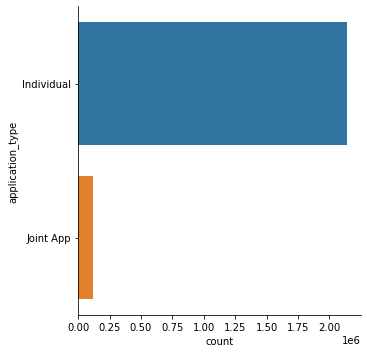

In [4]:
# Let's see application type
sns.catplot(kind='count', y='application_type', data=df)
plt.show()

1.  Our focus is on Single applicants, so we'll drop joint application
2.  We drop any features (columns) generated after loan approval  

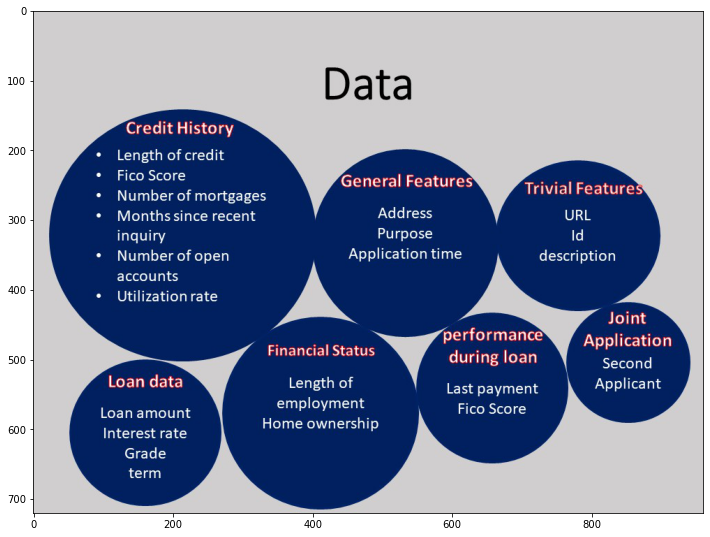

In [7]:
import matplotlib.image as mpimg
image = mpimg.imread("Presentation_LendingClub.jpg")
fig = plt.subplots(figsize=(12,10))
plt.imshow(image)
plt.show()

In [29]:
# Drop joint applications
mask = df['application_type'] == "Individual"
df = df[mask]

# Drop any features created during loan term
loan_term_features=['hardship_payoff_balance_amount', 'hardship_last_payment_amount','disbursement_method', 'debt_settlement_flag',
           'debt_settlement_flag_date', 'settlement_status', 'settlement_date','settlement_amount', 'settlement_percentage',
           'settlement_term', 'annual_inc_joint', 'dti_joint','last_fico_range_high', 'last_fico_range_low', 'total_rec_late_fee',
           'recoveries', 'collection_recovery_fee','last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
           'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
           'sec_app_fico_range_high','sec_app_earliest_cr_line', 'sec_app_inq_last_6mths','sec_app_mort_acc', 'sec_app_open_acc',
           'sec_app_revol_util','sec_app_open_act_il', 'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths',
           'sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog', 'hardship_flag', 'hardship_type',
           'hardship_reason', 'hardship_status', 'deferral_term','hardship_amount', 'hardship_start_date', 'hardship_end_date',
           'payment_plan_start_date', 'hardship_length', 'hardship_dpd','hardship_loan_status', 'orig_projected_additional_accrued_interest',
           'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag','debt_settlement_flag_date', 
           'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term', 'member_id', 'revol_bal_joint',
           'sec_app_fico_range_low', 'num_tl_120dpd_2m', 'num_tl_30dpd']
df.drop(columns=loan_term_features, axis=1, inplace=True)

# Drop trivial features
trivial_features = ['policy_code', 'application_type', 'pymnt_plan', 'url', 'title', 'zip_code', 'initial_list_status', 'id'] 
df.drop(columns=trivial_features, axis=1, inplace=True)


In [30]:
# Check missing data and drop columns with more than 40% missing values! There are 21 columns that we drop

missing1 = df.isna().sum()
missing2 = 100*df.isna().mean()
missing = pd.concat([missing1, missing2], axis=1)
missing.columns = ['count', '%']
null_list = missing.sort_values(by='%', ascending=False)[0:21].index
df.drop(columns=null_list, axis=1, inplace=True)

### Loan Purpose

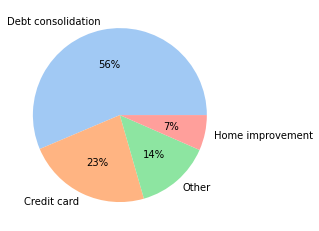

In [31]:
# What is the purpose for the loan

df['purpose'].replace(['small_business', 'major_purchase', 'house', 'vacation', 'car', 'medical', 'moving', 
                       'renewable_energy', 'wedding', 'educational'], 'other', inplace=True)
colors = sns.color_palette('pastel')[0:4]
#create pie chart
labels=['Debt consolidation', 'Credit card', 'Other',  'Home improvement' ]

plt.pie(df['purpose'].value_counts(), labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

### Applicant Employment Status

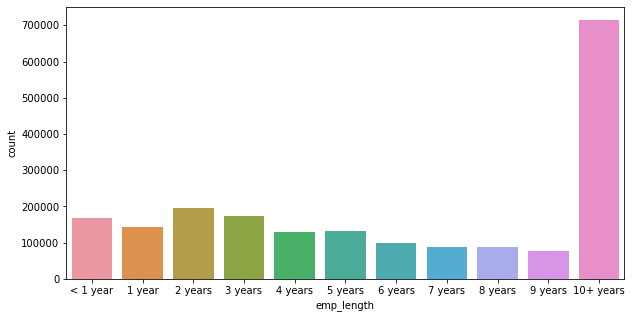

In [32]:
## Employment
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x="emp_length", data=df, ax=ax, order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years',
                                                    '7 years', '8 years', '9 years', '10+ years'])

# '<' and '+' will be problematic for visualization, we will replace them

df['emp_length'].replace('< 1 year', '1 year down', inplace=True)
df['emp_length'].replace('10+ years', '10 years up', inplace=True)


### Applicant Homeownership Status

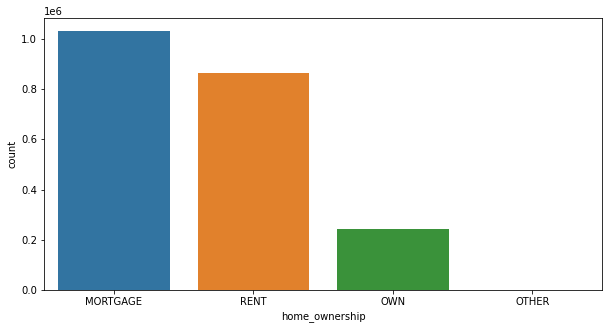

In [33]:
## Home ownership and verification status
df['home_ownership'].replace(['ANY', 'NONE'], 'OTHER', inplace=True)
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x="home_ownership", data=df, ax=ax)
df['verification_status'].replace('Source Verified', 'Verified', inplace=True)


### Loans Issued Each Year

<AxesSubplot:xlabel='issue_year', ylabel='count'>

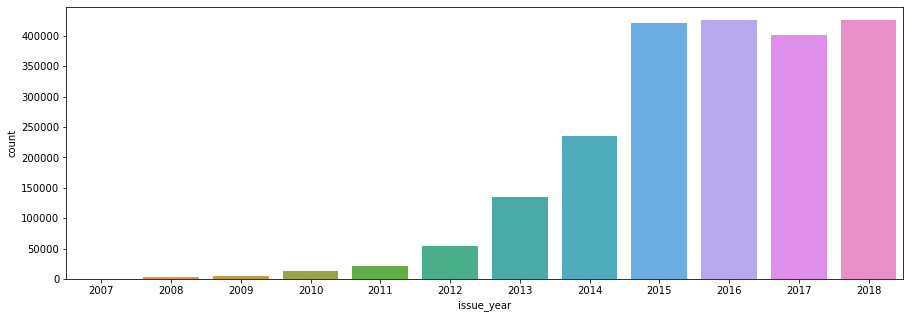

In [34]:
# Extracting year
df["issue_year"] = df["issue_d"].str[4:]
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="issue_year", data=df, ax=ax, order=["2007", '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'])

### Correlation Among Features

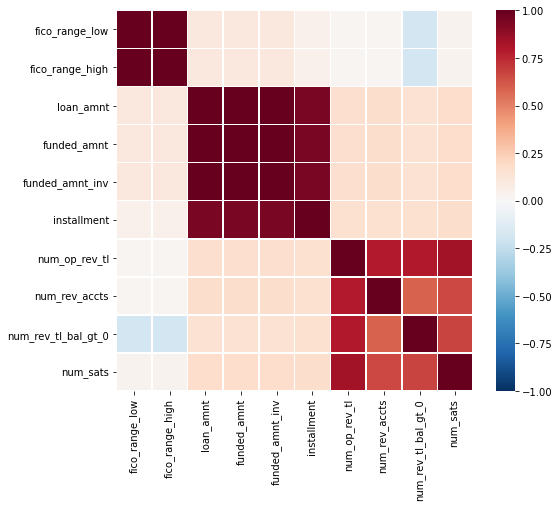

In [35]:
## Highly Correlated Features

dg = df[['fico_range_low', 'fico_range_high','loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',
        'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats']]
plt.figure(figsize = (8,7))
sns.heatmap(dg.corr() ,xticklabels=dg.corr().columns, yticklabels=dg.corr().columns,cmap="RdBu_r",linewidths=.6,vmin=-1, vmax=1);


In [36]:
# Some feature extraction

df['Credit Length (year)'] = (pd.to_datetime(df['issue_d'])-pd.to_datetime(df['earliest_cr_line']))/np.timedelta64(1,'Y')

df['fico_score'] = df[['fico_range_low', 'fico_range_high']].mean(axis=1)
df.drop(columns=['fico_range_low', 'fico_range_high', 'issue_d', 'earliest_cr_line'], axis=1, inplace=True)


In [37]:
dffloat = df.select_dtypes(np.number)
corr = dffloat.corr()


Based on the pearson correlation we can see the pairs of features with highly correlation, We will drop correlations higher than 0.75

loan_amnt is highly correlated with funded_amnt and funded_amnt_inv (1)

delinq_2yrs and num_tl_90g_dpd_24m 0.66

open_acc and total_acc (0.7) , num_op_rev_tl (0.83), num_actv_rev_tl (0.65), num_bc_sats (.66)

pub_rec and tax_liens (.71) and pub_rec_bankruptcies (.63)

revol_util and bc_util (0.87) and percent_bc_gt_75 (0.73)

total_acc and num_il_tl (0.7) and num_rev_accts (0.75)

tot_cur_bal and avg_cur_bal (0.83)

open_il_12m and num_tl_op_past_12m (0.55)

total_rev_hi_lim and total_bc_limit (0.80) and bc_open_to_buy (0.68)

avg_cur_bal and tot_hi_cred_lim (0.79) and tot_cur_bal (0.83)

bc_open_to_buy and total_bc_limit(0.87)

mo_sin_old_rev_tl_op and Credit Length (year) (0.9)

num_actv_bc_tl and num_rev_tl_bal_gt_0 (0.82)

num_actv_rev_tl and num_op_rev_tl (0.78) and num_rev_tl_bal_gt_0 (1)

num_bc_sats and num_bc_tl (0.76) and num_op_rev_tl (0.79)

num_op_rev_tl and num_rev_accts (0.8) and num_rev_tl_bal_gt_0 (0.78) and num_sats (0.83)

num_tl_30dpd and acc_now_delinq (0.8)

num_tl_op_past_12m and acc_open_past_24mths (0.77)

percent_bc_gt_75 and revol_util (0.73)

tot_hi_cred_lim and tot_cur_bal (0.79)

total_bal_ex_mort and total_il_high_credit_limit (0.89)

total_bc_limit and bc_open_to_buy (0.87) and total_rev_hi_lim (0.8)

total_il_high_credit_limit and total_bal_ex_mort (0.89)

Credit length and mon_sin_old_rev_tl_op (0.90)

In [38]:
correlated_list = ['funded_amnt', 'funded_amnt_inv', 'mo_sin_rcnt_rev_tl_op', 'open_acc', 'num_op_rev_tl', 'pub_rec', 
                   'bc_util', 'percent_bc_gt_75', 'num_il_tl', 'num_rev_accts', 'avg_cur_bal', 'total_rev_hi_lim', 'bc_open_to_buy',
                   'num_rev_tl_bal_gt_0', 'num_op_rev_tl', 'num_bc_tl', 'num_rev_accts', 'num_sats', 'acc_now_delinq', 
                   'acc_open_past_24mths', 'percent_bc_gt_75', 'tot_cur_bal', 'total_il_high_credit_limit', 'num_tl_90g_dpd_24m',
                   'mo_sin_old_rev_tl_op', 'num_actv_bc_tl', 'num_actv_rev_tl', 'installment', 'pct_tl_nvr_dlq', 'tot_coll_amt',
                   'num_bc_sats', 'revol_bal', 'total_bal_ex_mort']
df.drop(columns=correlated_list, axis=1, inplace=True)

## Histograms of Numerical Features

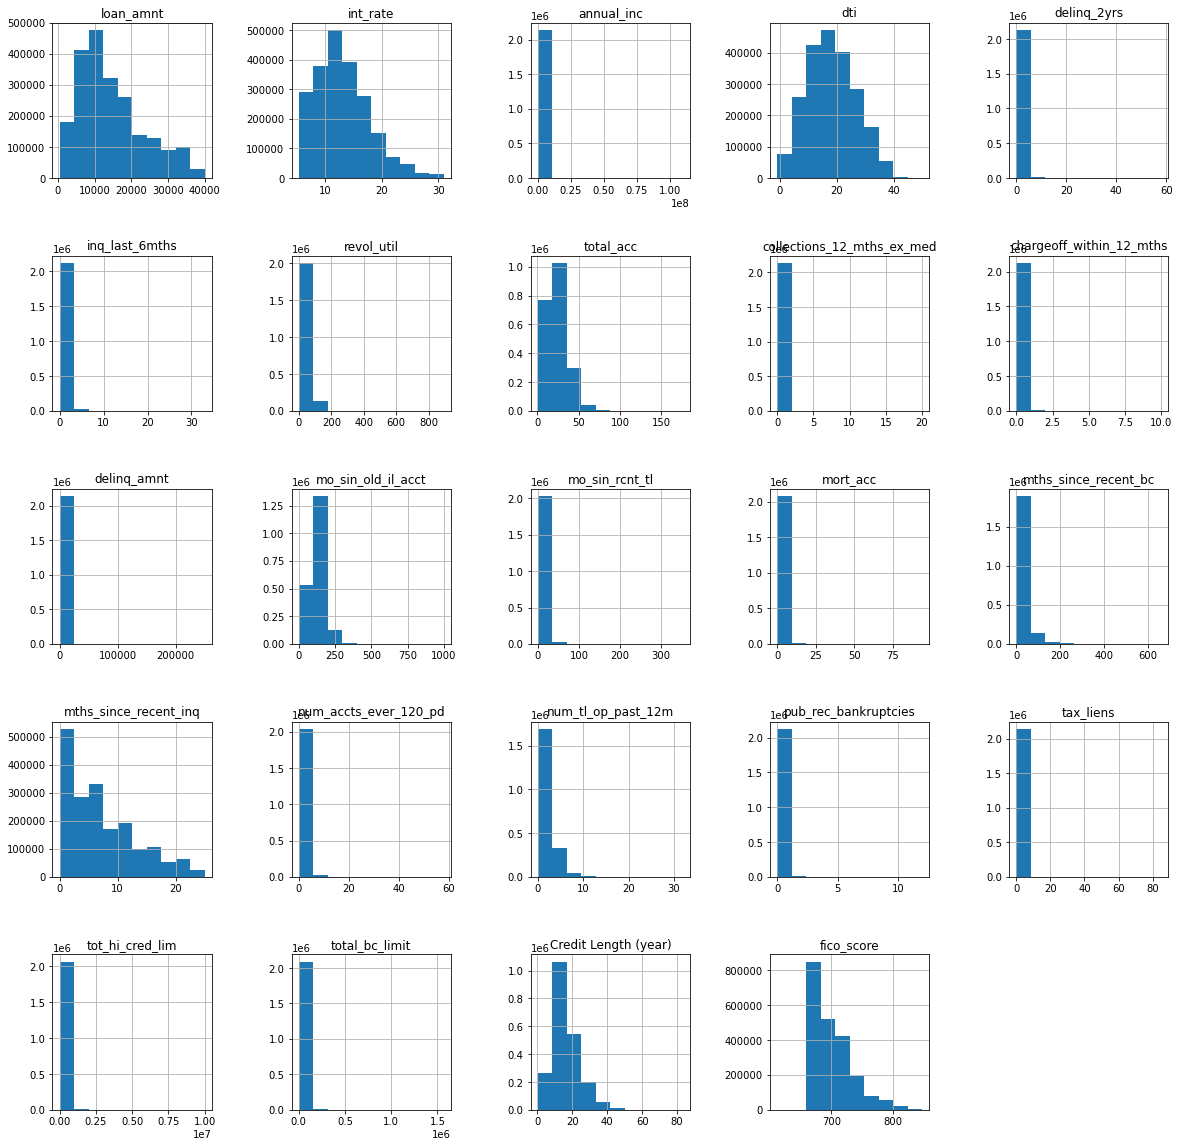

In [39]:
df.select_dtypes(np.number).hist(figsize=(20,20))
plt.subplots_adjust(hspace=0.5, wspace=.5);

## Loan Status

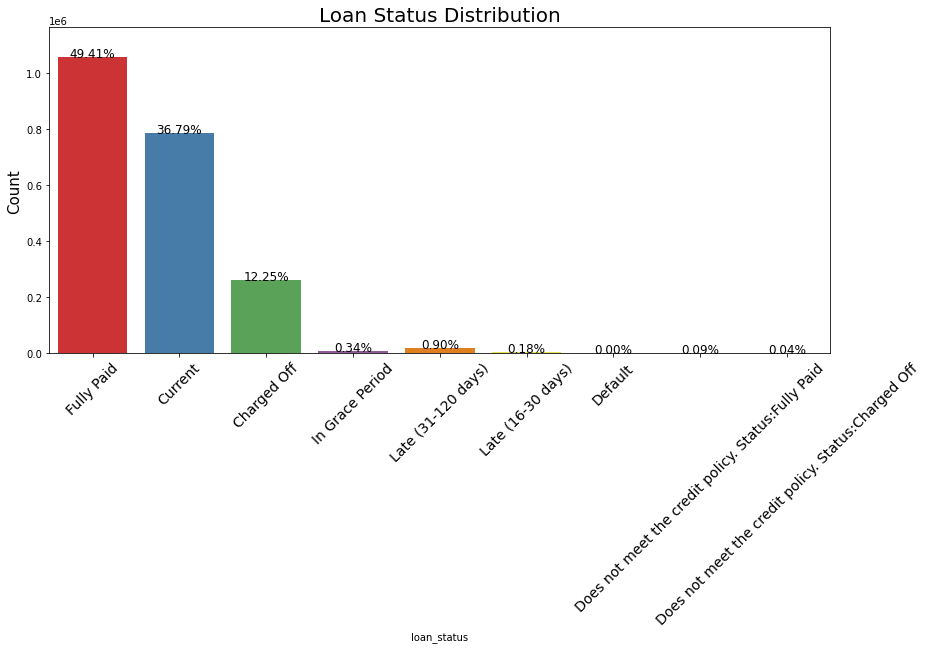

In [40]:
total = len(df)

plt.figure(figsize = (14,6))

ax = sns.countplot(x="loan_status", data=df, palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, fontsize=14)
#ax.set_xlabel("Loan Status Categories", fontsize=14)
ax.set_ylabel("Count", fontsize=15)
ax.set_title("Loan Status Distribution", fontsize=20)
sizes=[]
for p in ax.patches:
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2., height + 0, '{:1.2f}%'.format(height/total*100), ha="center", fontsize=12) 

    ax.set_ylim(0, max(sizes) * 1.10)

plt.show()

##  Is Charged Off similar to Default?

As it is shown in the above graph only a very small number of loans are default. A question that is raised by looking at the graph is what charged-off means. A google search led us to the lending club webpage . Briefly, a default is when the borower is late and charged off happens when the creditors gives up hope on getting the loan back. So default is the beginning of the process which may or may not lead to charge off. 

In [41]:
# We will drop current loans 
mask = df['loan_status'] != "Current"
df = df[mask]
df['loan_status'].replace(['Default', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)'], 'Charged Off', inplace=True)
df['loan_status'].replace('Does not meet the credit policy. Status:Fully Paid', 'Fully Paid', inplace=True )
df['loan_status'].replace('Does not meet the credit policy. Status:Charged Off', 'Charged Off', inplace=True )

df['loan_status'].value_counts()


Fully Paid     1059283
Charged Off     293484
Name: loan_status, dtype: int64

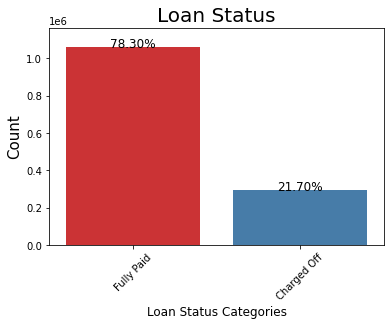

In [42]:
total = len(df)

plt.figure(figsize = (6,4))

ax = sns.countplot(x="loan_status", data=df, palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_xlabel("Loan Status Categories", fontsize=12)
ax.set_ylabel("Count", fontsize=15)
ax.set_title("Loan Status", fontsize=20)
sizes=[]
for p in ax.patches:
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
ax.set_ylim(0, max(sizes) * 1.10)

plt.show()

## Exploratory Data Analysis and Effect of Features on Loan Charged Off

In [43]:
df.drop(columns=['issue_year'], inplace=True)

In [44]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_tl_op_past_12m', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bc_limit',
       'Credit Length (year)', 'fico_score'],
      dtype='object')

In [45]:
# Create array for using the function for different plots
numeric_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs','inq_last_6mths', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'delinq_amnt','mo_sin_old_il_acct', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq','num_accts_ever_120_pd','num_tl_op_past_12m',
       'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bc_limit','Credit Length (year)', 'fico_score']

categorical_features = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose']




In [46]:
#function for numeric features plot
def numeric_plot(feature):
    fig, ax = plt.subplots(figsize=(8,4))
    
    s1 = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', feature], 'Charged Off': df.loc[df['loan_status']=='Charged Off', feature]}, index=None)
    ax.hist(s1, stacked=True, bins=20, rwidth=0.85, color=["saddlebrown", "sandybrown"])
    ax.set_title(f'Loan Status vs {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    
    p = ax.patches
    for i in range(0,20,1):
        x1, y1 = p[i].get_xy()
        x2, y2 = p[i+1].get_xy()
        x = x1 
        Y1 = p[i].get_height()
        Y2 = p[i+20].get_height()
        y = Y2 + Y1
        a = Y2/(Y2 + Y1)
        ax.text(x, y, round(a*100,1), rotation=45)
    
    plt.tight_layout()

#function for categorical features plot
def categorical_plot(feature):
    fig, ax = plt.subplots(figsize=(10,6))

    s4 = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', feature].value_counts(), 'Charged Off': df.loc[df['loan_status']=='Charged Off', feature].value_counts()})

    s4.plot.bar(stacked=True, ax=ax, color=["saddlebrown", "sandybrown"])

    ax.set_title(f'Loan Status vs {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    p = ax.patches
    n = int(s4['Fully Paid'].unique().size)
    for i in range(0,n,1):
        x1, y1 = p[i].get_xy()
        x2, y2 = p[i+1].get_xy()
        x = x1 
        Y1 = p[i].get_height()
        Y2 = p[i+n].get_height()
        y = Y2 + Y1
        a = Y2/(Y2 + Y1)
        ax.text(x, y, round(a*100,1), rotation=45)   
    plt.tight_layout()

In [ ]:
color_pallete =[[], ]

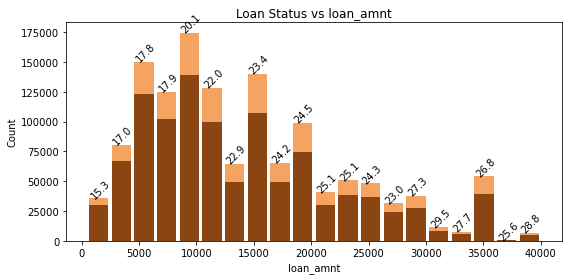

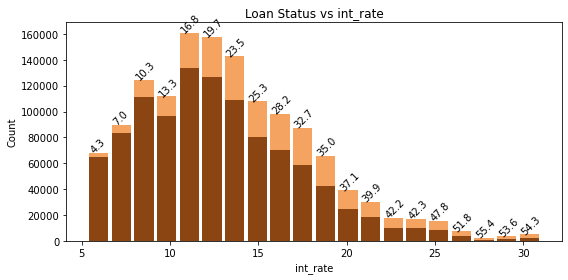

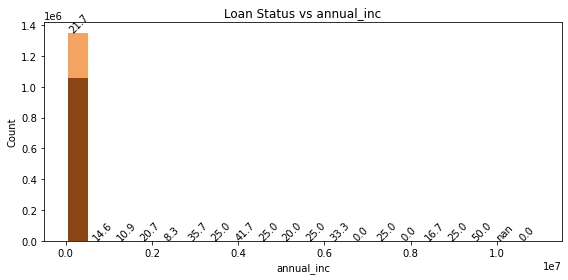

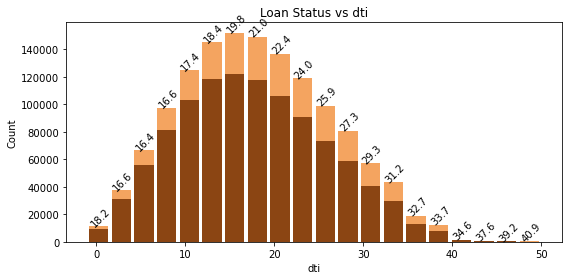

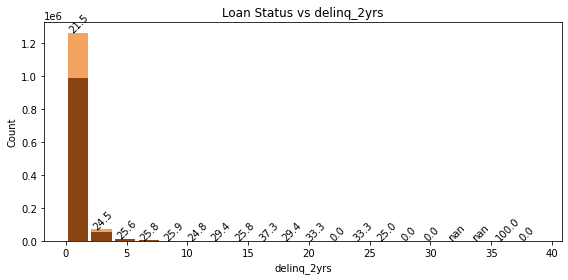

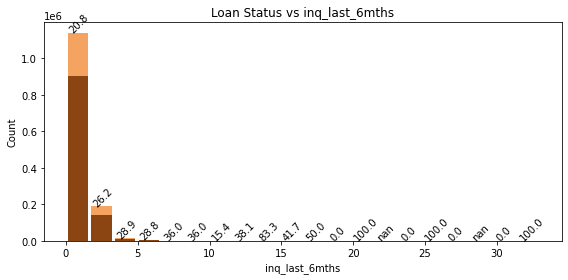

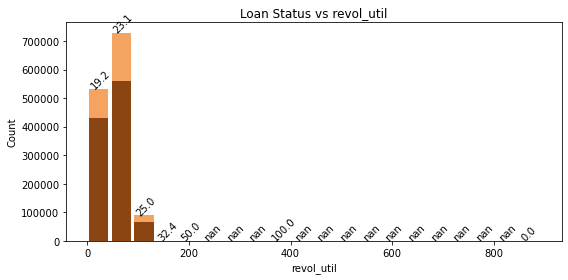

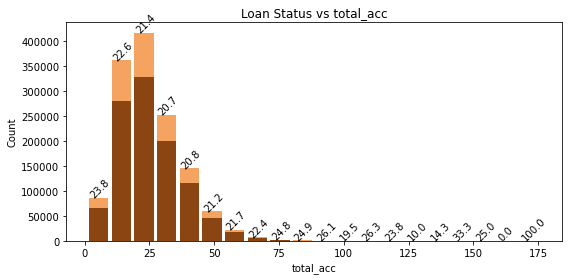

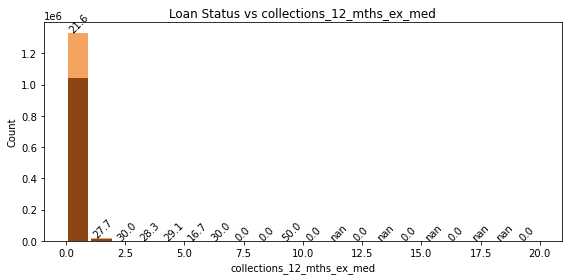

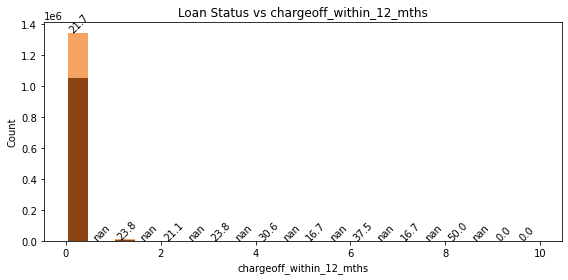

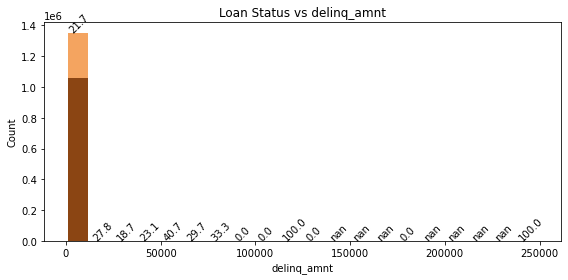

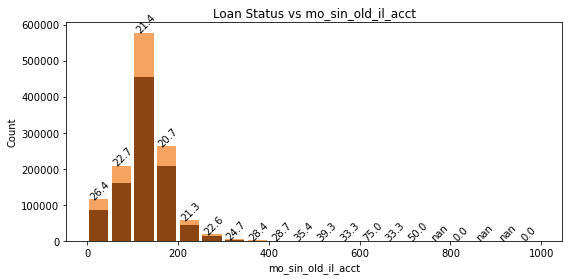

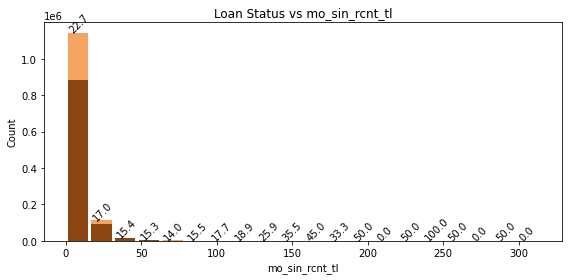

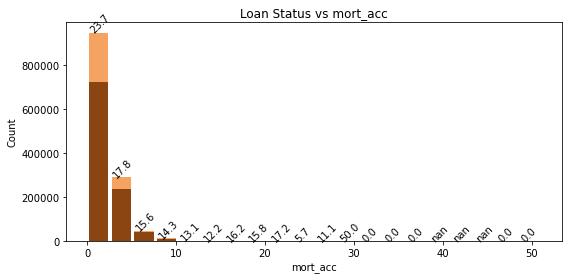

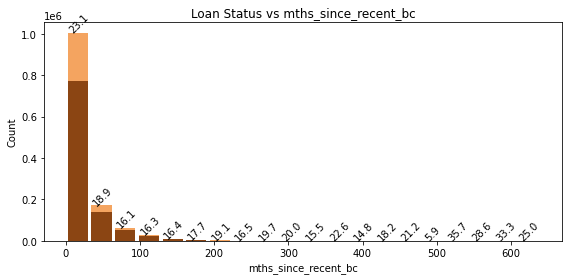

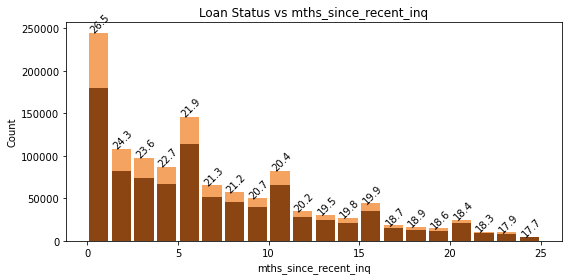

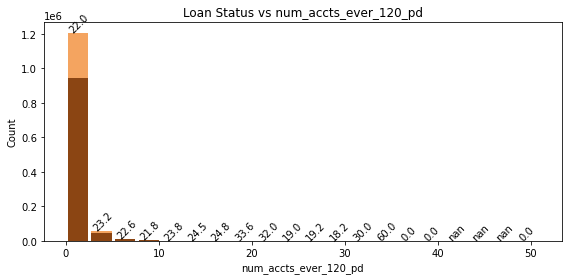

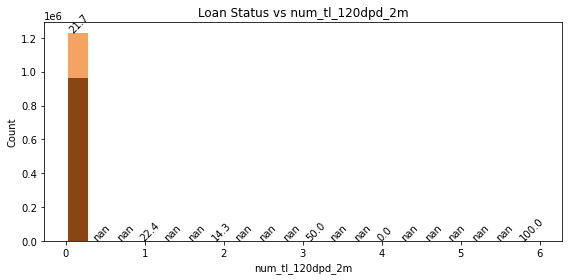

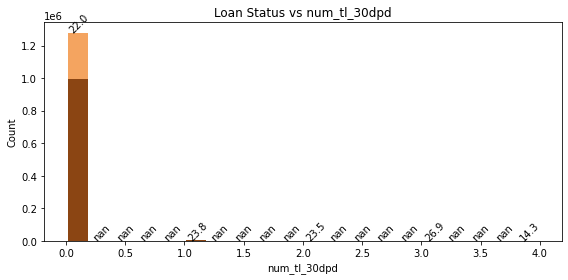

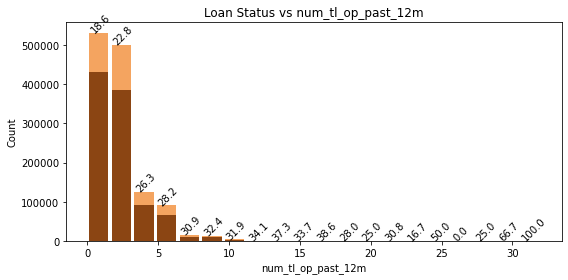

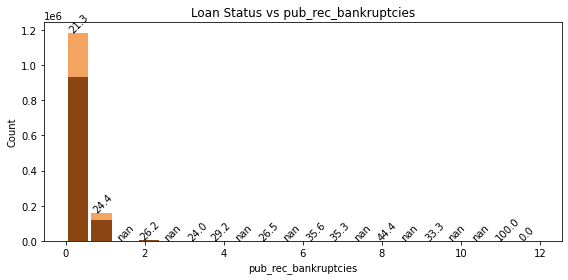

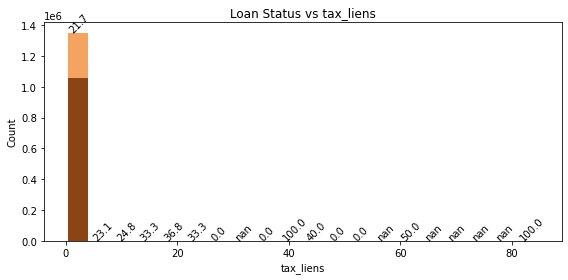

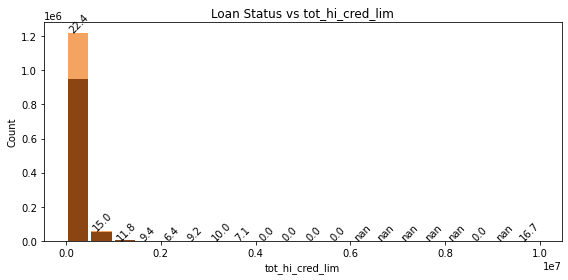

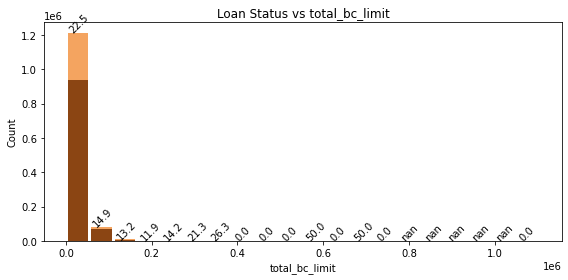

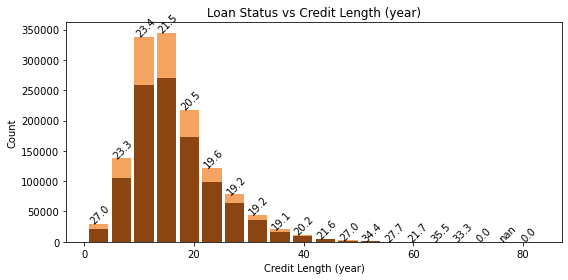

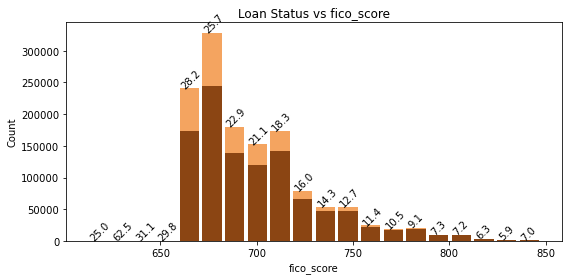

In [59]:
# Show the plots
for feature in numeric_features:
    numeric_plot(feature)

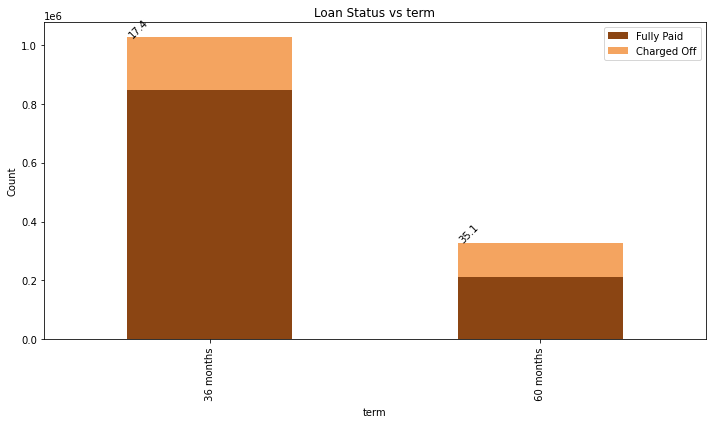

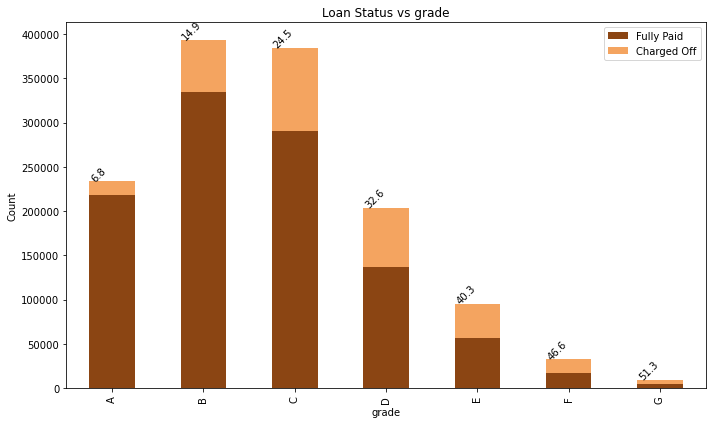

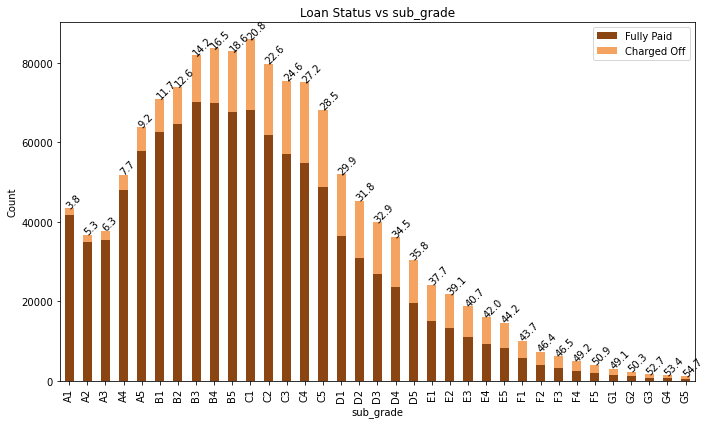

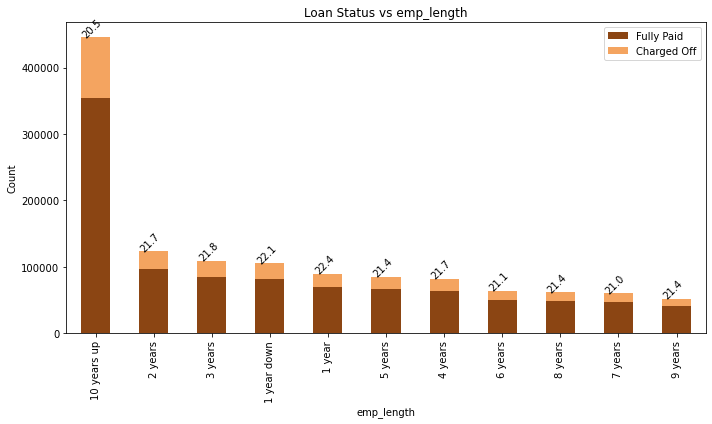

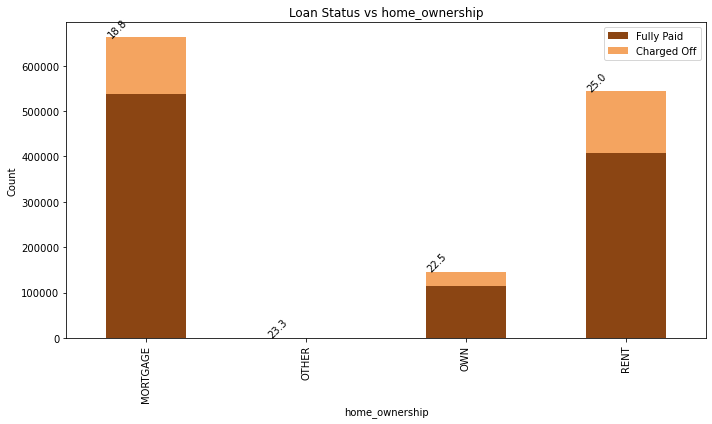

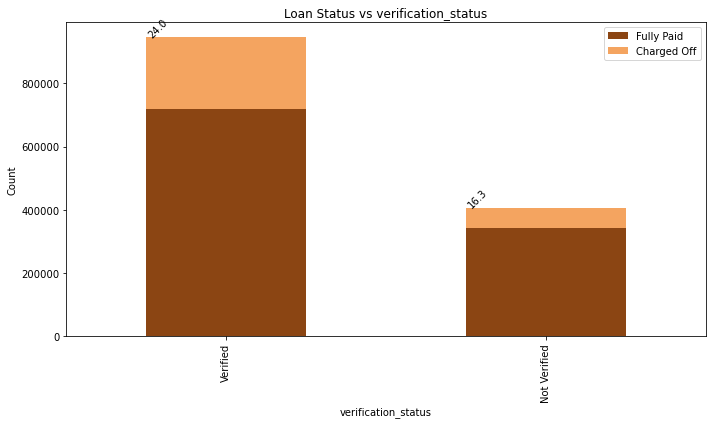

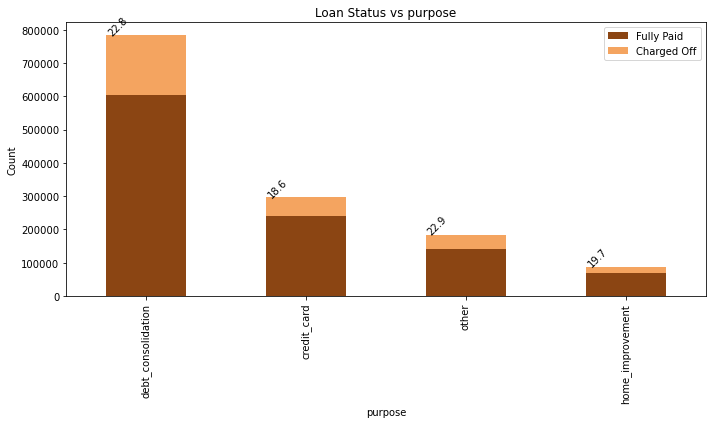

In [83]:
# Show the plots
for feature in categorical_features:
    categorical_plot(feature)

## Shall we treat states equally? Does the applicant's residential state affect their performance? 
In order to find out if states are different, first the population of each state was found and the number of loans issued per 10,000 was estimated in each state. Then the percentage of defaulted and fully-paid loans were determined and shown in the figure. NV has the highest number of loans issued per 10,000 capita and IA has the lowest number of loans issued per 10,000 capita. However, 50% of loans issued in IA are finally defaulted. Does this mean that IA residents perform significantly worse than other states' residents? To answer this question, we had a closer look at IA. There are only two loans issued in this state, which is a very small number to make any hypothesis.

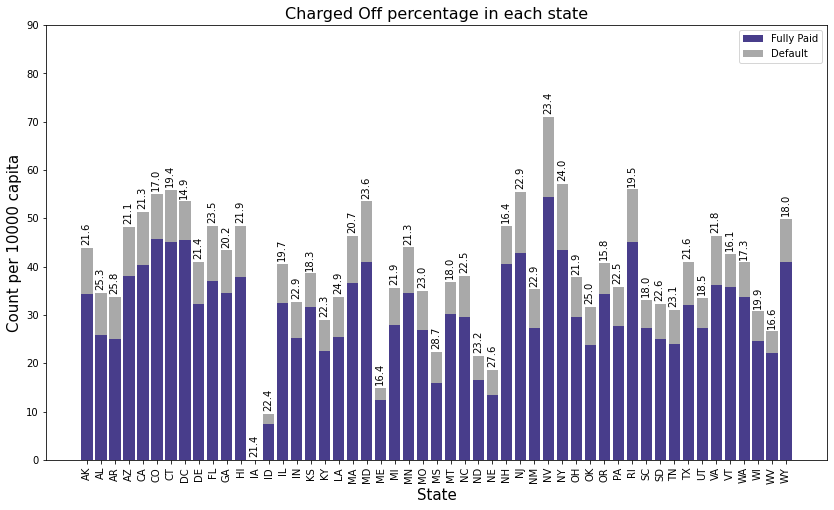

In [87]:
# Loading the data of each state population

Path = "C:\\Users\\somfl\\Documents\\Data Science Career Track\\LendingClub\\population.csv"
pop = pd.read_csv(Path, sep=" ")
pop = pop.set_index('abb')

# Count the number of fully paid and defaulted loans in each state
s = pd.DataFrame({'Charged Off': df.loc[df['loan_status']=='Charged Off', ['addr_state']].value_counts(),
                  'Fully Paid': df.loc[df['loan_status']=='Fully Paid', ['addr_state']].value_counts()})
listIndex = s.index
new = []
for item in listIndex:
    new.append(''.join(item))
s.index = new

# Joining population data with loan data

s1 = s.join(pop)
s1['Total'] = s1['Charged Off'] + s1['Fully Paid']
s1['Charged_Off_per_10000'] = s1['Charged Off']/s1['population']*10000
s1['FullyPaid_per_10000'] = s1['Fully Paid']/s1['population']*10000

fig, ax =plt.subplots(nrows=1, ncols=1, figsize=(14,8))

ax.bar(s1.index, s1['FullyPaid_per_10000'], color="darkslateblue")
ax.bar(s1.index, s1['Charged_Off_per_10000'], bottom=s1['FullyPaid_per_10000'], color="darkgrey")
ax.set_xticklabels(s1.index, rotation=90)
ax.set_ylabel('Count per 10000 capita', fontsize=15)
ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('State', rotation=0, fontsize=15)
ax.set_title('Charged Off percentage in each state', fontsize=16)
ax.set_ylim([0,90])
p = ax.patches
heights = [patch.get_height() for patch in p]

length = len(new)
for i in range(0,length,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 
    Y1 = p[i].get_height()
    Y2 = p[i+length].get_height()
    y = Y2 + Y1 + 1
    a = Y2/(Y2 + Y1)
    plt.text(x, y, round(a*100,1), rotation=90)

plt.show()


## Analysis of loan sub_grade, interest rate

Below, boxplots of interest rate and fico score versus loan subgrades are shown. As discussed earlier there are 5 grades (A to G) and in each grade there are 7 sub-levels. Based on an applicant's qualifications, A1 is the best subgrade an applicant can have and G5 is the worst. It can be seen that applications in G5 have lower fico scores and higher interest rates. Interest rates increases from grade A to G and reaches a plateau in grade G.

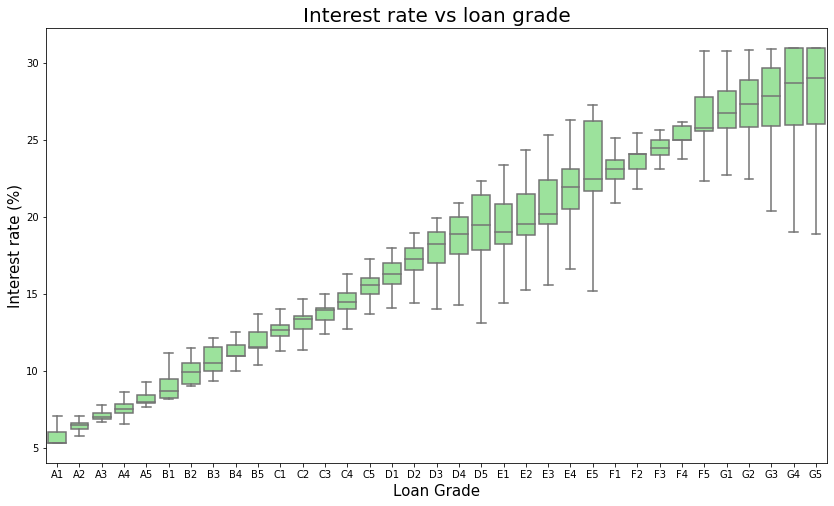

In [88]:
fig, ax=plt.subplots(figsize=(14, 8))
sns.boxplot(x="sub_grade", y="int_rate", data=df, order =['A1','A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4',
                                            'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3',
                                            'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5'], sym="", color='lightgreen', ax=ax)

#ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('Loan Grade', fontsize=15)
ax.set_ylabel('Interest rate (%)', fontsize=15)
ax.set_title("Interest rate vs loan grade", fontsize=20)

plt.show()

In [90]:
df['grade_int'] = df['sub_grade'].map({'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5,
                                      'B1':6, 'B2':7, 'B3':8, 'B4':9, 'B5':10,
                                      'C1':11, 'C2':12, 'C3':13, 'C4':14, 'C5':15,
                                      'D1':16, 'D2':17, 'D3':18, 'D4':19, 'D5':20,
                                      'E1':21, 'E2':22, 'E3':23, 'E4':24, 'E5':25,
                                      'F1':26, 'F2':27, 'F3':28, 'F4':29, 'F5':30,
                                      'G1':31, 'G2':32, 'G3':33, 'G4':34, 'G5':35})

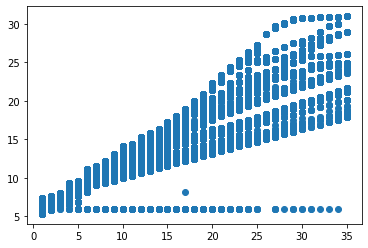

In [100]:
plt.scatter(x=df['grade_int'], y=df['int_rate'])


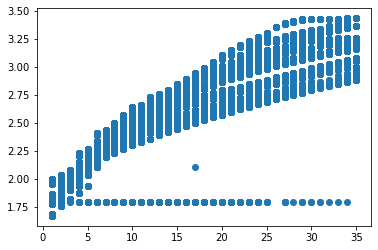

In [99]:
plt.scatter(x=df['grade_int'], y=np.log(df['int_rate']))


In [47]:

# Total Loan Amount Cost
cost = df.groupby('loan_status').loan_amnt.sum().sort_values(ascending=False)
# Showing the amounts in $bn 
print("Fully paid loans: $"+str(round(cost[0]/1e9,1))+"bn")
print("Charged off loans: $"+str(round(cost[1]/1e9,1))+"bn")

Fully paid loans: $14.9bn
Charged off loans: $4.6bn


In [48]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_tl_op_past_12m', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bc_limit',
       'Credit Length (year)', 'fico_score'],
      dtype='object')

In [49]:
df.dropna(inplace=True)

## Preprocessing and Modeling

In [50]:
categorical_columns = ['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose']

numerical_columns = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'revol_util', 
                     'total_acc', 'collections_12_mths_ex_med','chargeoff_within_12_mths', 'mo_sin_old_il_acct',
                     'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc','mths_since_recent_inq', 'num_accts_ever_120_pd',
                     'num_tl_op_past_12m', 'pub_rec_bankruptcies','tax_liens', 'tot_hi_cred_lim', 'total_bc_limit', 
                     'fico_score','Credit Length (year)']


yy = df['loan_status']
XX = df[numerical_columns + categorical_columns]

X_cols = XX.columns
y_col = ['status']

Xn = XX.to_numpy()
yn = yy.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

X = pd.DataFrame(X_res, columns=X_cols)
y = pd.DataFrame(y_res, columns=y_col)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)


categorical_pipe_s = Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary'))])
numerical_pipe_s = Pipeline(steps=[('scaler', MinMaxScaler()), ('feature', SelectKBest(chi2))])

preprocessing_s = ColumnTransformer(
    [
        ("cat", categorical_pipe_s, categorical_columns),
        ("num", numerical_pipe_s, numerical_columns),
    ]
)


In [51]:
grid_params = {'preprocess__num__feature__k': [k+1 for k in range(len(numerical_columns))]}

lr_select = Pipeline(
    [
        ("preprocess", preprocessing_s),
        ("classifier", LogisticRegression(C=100, penalty='l2', random_state=42))
    ]
)
grid_cv = GridSearchCV(lr_select, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         ['term',
                                                                          'emp_length',
                                                                          'home_ownership',
                                                                          'verification_status',
                                                                          'purpose']),
                                                                        ('num',
                                                                         Pipeline(steps=[('sca

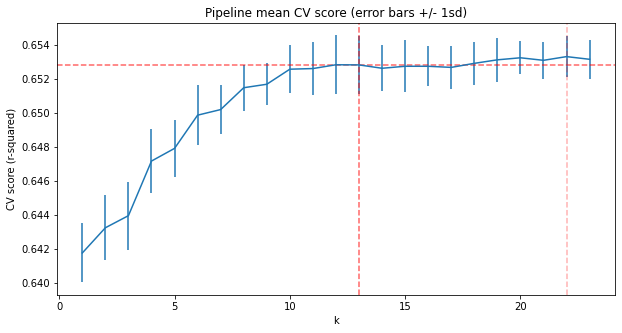

In [57]:
score_mean = grid_cv.cv_results_['mean_test_score']
score_std = grid_cv.cv_results_['std_test_score']
cv_k = [i for i in grid_cv.cv_results_['param_preprocess__num__feature__k']]
best_k = grid_cv.best_params_['preprocess__num__feature__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.3)
#plt.axhline(y=.653, c='r', ls='--', alpha=.3)
plt.axhline(y=.6528, c='r', ls='--', alpha=.6)
plt.axvline(x=13, c='r', ls='--', alpha=.6)

plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
#plt.xlim([0.5,0.6])
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [59]:
categorical_pipe_13 = Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary'))])
numerical_pipe_13 = Pipeline(steps=[('scaler', MinMaxScaler()), ('feature', SelectKBest(chi2, k=13))])

preprocessing_13 = ColumnTransformer(
    [
        ("cat", categorical_pipe_13, categorical_columns),
        ("num", numerical_pipe_13, numerical_columns),
    ]
)
lr_select13 = Pipeline(
    [
        ("preprocess", preprocessing_13),
        ("classifier", LogisticRegression(random_state=42))
    ])

grid_params = {'classifier__penalty': ['l1','l2'],
               'classifier__C': [0.1,100]
              }
  

grid_cv13 = GridSearchCV(lr_select13, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
grid_cv13.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         ['term',
                                                                          'emp_length',
                                                                          'home_ownership',
                                                                          'verification_status',
                                                                          'purpose']),
                                                                        ('num',
                                                                         Pipeline(steps=[('sca

In [60]:
selected = grid_cv13.best_estimator_.named_steps.preprocess.named_transformers_.num.named_steps.feature.get_support()
selected_num = []
for i in range(len(selected)):
    if selected[i]==True:
        selected_num.append(numerical_columns[i])
selected_num 

['loan_amnt',
 'int_rate',
 'dti',
 'inq_last_6mths',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_tl_op_past_12m',
 'tot_hi_cred_lim',
 'total_bc_limit',
 'fico_score',
 'Credit Length (year)']

## Logistic Regression

In [61]:
categorical_columns = ['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose']

numerical_columns = ['loan_amnt',
 'int_rate',
 'dti',
 'inq_last_6mths',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_tl_op_past_12m',
 'tot_hi_cred_lim',
 'total_bc_limit',
 'fico_score',
 'Credit Length (year)'] 
yy = df['loan_status']
XX = df[numerical_columns + categorical_columns]

X_cols = XX.columns
y_col = ['status']

Xn = XX.to_numpy()
yn = yy.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

X = pd.DataFrame(X_res, columns=X_cols)
y = pd.DataFrame(y_res, columns=y_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)


categorical_pipe = Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary'))])
numerical_pipe = Pipeline(steps=[('scaler', MinMaxScaler())])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_pipe, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)
lr_modify = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", LogisticRegression(random_state=42))
    ])

grid_params = {'classifier__penalty': ['l1','l2'],
               'classifier__C': [0.1,100]
              }
  

grid_cv = GridSearchCV(lr_modify, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         ['term',
                                                                          'emp_length',
                                                                          'home_ownership',
                                                                          'verification_status',
                                                                          'purpose']),
                                                                        ('num',
                                                                         Pipeline(steps=[('sca

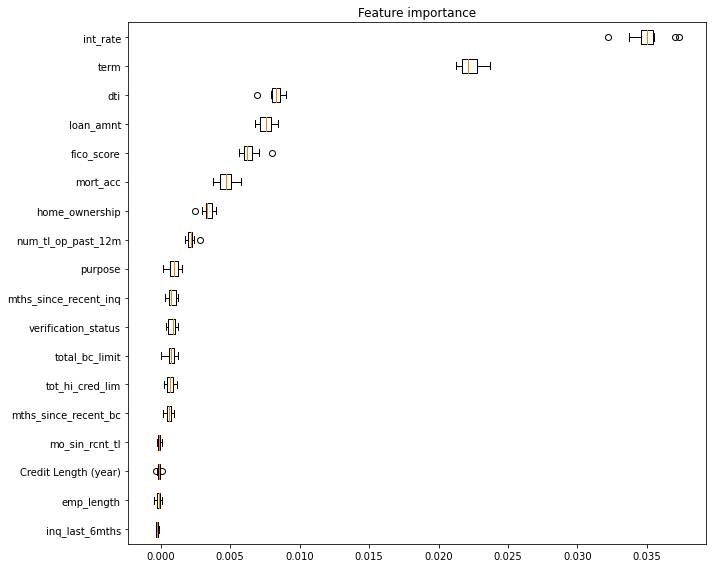

In [62]:
result = permutation_importance(
    grid_cv.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Feature importance")
fig.tight_layout()
plt.show()

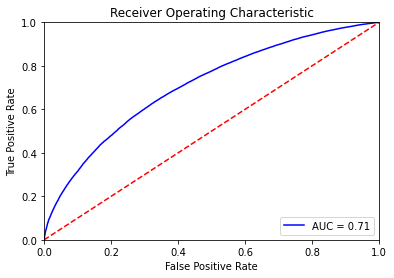

In [63]:
y_pred = grid_cv.best_estimator_.predict(X_test)
y_prob = grid_cv.best_estimator_.predict_proba(X_test)
probs = y_prob[:,1]
FalsePositiveRate, TruePositiveRate, threshold = metrics.roc_curve(y_test, probs, pos_label='Fully Paid')
roc_auc = metrics.auc(FalsePositiveRate, TruePositiveRate)

plt.title('Receiver Operating Characteristic')
plt.plot(FalsePositiveRate, TruePositiveRate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## XGBOOST

[12:33:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


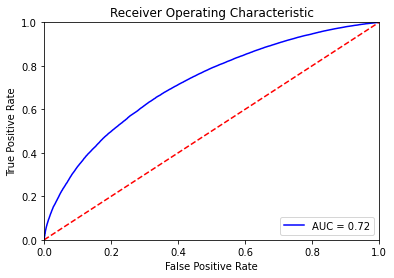

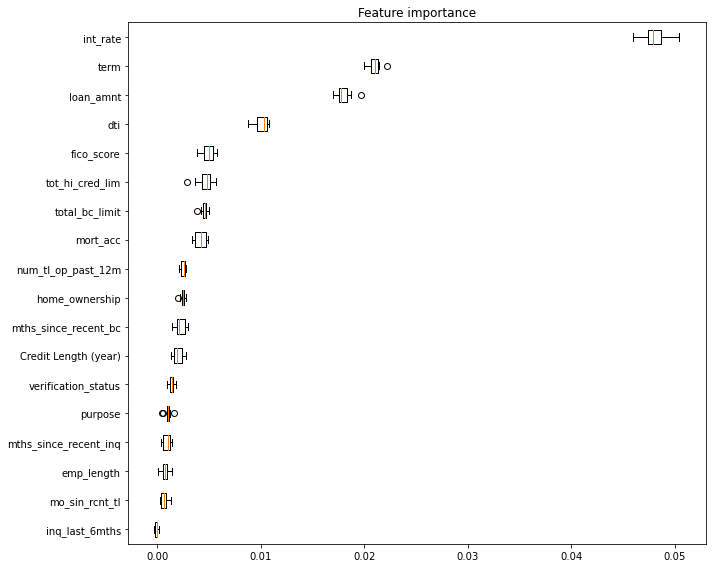

In [64]:
gb = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", XGBClassifier(random_state=42))
    ])

param_grid = { 
    'classifier__learning_rate': [0.25, 0.2, 0.1],
    'classifier__max_depth': [3, 6, 9]
}

    
grid_cv_gb = GridSearchCV(gb, param_grid=param_grid, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
grid_cv_gb.fit(X_train, y_train)

y_pred = grid_cv_gb.best_estimator_.predict(X_test)
y_prob = grid_cv_gb.best_estimator_.predict_proba(X_test)
probs = y_prob[:,1]
FalsePositiveRate, TruePositiveRate, threshold = metrics.roc_curve(y_test, probs, pos_label='Fully Paid')
roc_auc = metrics.auc(FalsePositiveRate, TruePositiveRate)

plt.title('Receiver Operating Characteristic')
plt.plot(FalsePositiveRate, TruePositiveRate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

result = permutation_importance(
    grid_cv_gb.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Feature importance")
fig.tight_layout()
plt.show()

interest rate can be assumed correllated to other parameters, let's drop it and do the model and see the result.
## Model without interest rate

[12:47:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


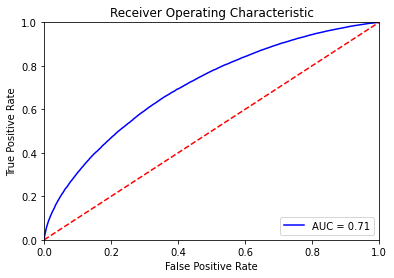

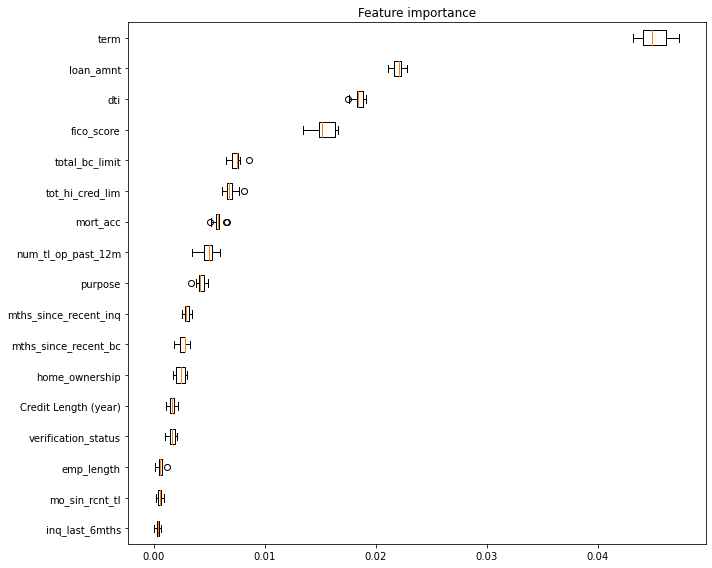

In [65]:
categorical_columns = ['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose']

numerical_columns = ['loan_amnt',
 'dti',
 'inq_last_6mths',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_tl_op_past_12m',
 'tot_hi_cred_lim',
 'total_bc_limit',
 'fico_score',
 'Credit Length (year)'] 
yy = df['loan_status']
XX = df[numerical_columns + categorical_columns]

X_cols = XX.columns
y_col = ['status']

Xn = XX.to_numpy()
yn = yy.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

X = pd.DataFrame(X_res, columns=X_cols)
y = pd.DataFrame(y_res, columns=y_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)


categorical_pipe = Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary'))])
numerical_pipe = Pipeline(steps=[('scaler', MinMaxScaler())])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_pipe, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)

  

gb = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", XGBClassifier(random_state=42))
    ])

param_grid = { 
    'classifier__learning_rate': [0.25, 0.2, 0.1],
    'classifier__max_depth': [3, 6, 9]
}

    
grid_cv_gb = GridSearchCV(gb, param_grid=param_grid, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
grid_cv_gb.fit(X_train, y_train)

y_pred = grid_cv_gb.best_estimator_.predict(X_test)
y_prob = grid_cv_gb.best_estimator_.predict_proba(X_test)
probs = y_prob[:,1]
FalsePositiveRate, TruePositiveRate, threshold = metrics.roc_curve(y_test, probs, pos_label='Fully Paid')
roc_auc = metrics.auc(FalsePositiveRate, TruePositiveRate)

plt.title('Receiver Operating Characteristic')
plt.plot(FalsePositiveRate, TruePositiveRate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

result = permutation_importance(
    grid_cv_gb.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Feature importance")
fig.tight_layout()
plt.show()